# Defacing pre-registration - Exploratory analysis in R

## Load manual ratings

In [35]:
# Load ratings
df <- read.csv("../../data/IXI_augmented_ratings_df.tsv", sep="\t")
head(df)

randomized_id rater_id dataset                         rating time_sec
1 sub-0152_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55   314.549 
2 sub-1051_T1w  rater_02 IXI dataset - MRIQC derivatives 2.85   150.737 
3 sub-1186_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55   104.950 
4 sub-0951_T1w  rater_02 IXI dataset - MRIQC derivatives 3.45    84.569 
5 sub-0902_T1w  rater_02 IXI dataset - MRIQC derivatives 2.95    68.889 
6 sub-0250_T1w  rater_02 IXI dataset - MRIQC derivatives 2.55    90.318 
  artifacts                                           confidence
1 ["noise-global","inu","processing","uncategorized"] 2.50      
2 ["noise-local","processing"]                        3.50      
3 ["wrap-around","uncategorized"]                     3.35      
4 ["inu"]                                             3.50      
5 ["processing"]                                      3.50      
6 ["uncategorized"]                                   3.15      
  comments                                                                                     
1 blurry, smooth image, A bit of signal dropout in frontal                                     
2 Smooth. but seems to be the case of most of the images of the dataset                        
3 Slightly short FoV in frontal, bordeline cutting the cortex, Small artefact in the background
4                                                                                              
5                                                                                              
6 looks like a bit of drop out in frontal and a bit of background artefact                     
  defaced subject
1 1        72    
2 0       354    
3 0       205    
4 1       446    
5 1       248    
6 0       437

Let us verify that each rater rated all 450 images.

In [36]:
raters <- list('rater_01', 'rater_02', 'rater_03', 'rater_04')
for (rater in raters) {
  df_rater <- subset(df, rater_id == rater)
  # If an image was assigned several ratings by the same rater, we keep only the last one
  df_unique <- df_rater[!duplicated(df_rater[c("rater_id", "randomized_id")], fromLast = TRUE), ]
  print(paste(rater, ":", nrow(df_unique), "images rated"))
}

[1] "rater_01 : 450 images rated"
[1] "rater_02 : 450 images rated"
[1] "rater_03 : 450 images rated"
[1] "rater_04 : 450 images rated"


In [37]:
library(dplyr)

# Remove information we will not use in this analysis
df <- subset(df, select = c("rater_id", "rating", "defaced", "subject"))

#Plot just the first few rows for making the notebook less lengthy
head(df)

rater_id rating defaced subject
1 rater_02 2.55   1        72    
2 rater_02 2.85   0       354    
3 rater_02 2.55   0       205    
4 rater_02 3.45   1       446    
5 rater_02 2.95   1       248    
6 rater_02 2.55   0       437

# Plot ratings distribution

In [38]:
# Convert defaced to factor for better visualization
df$defaced <- factor(df$defaced, levels = c(0, 1), labels = c("Nondefaced", "Defaced"))

To explore whether a bias is visible in the data, we plot for each rater the distribution of the ratings extracted from non-defaced versus defaced images.

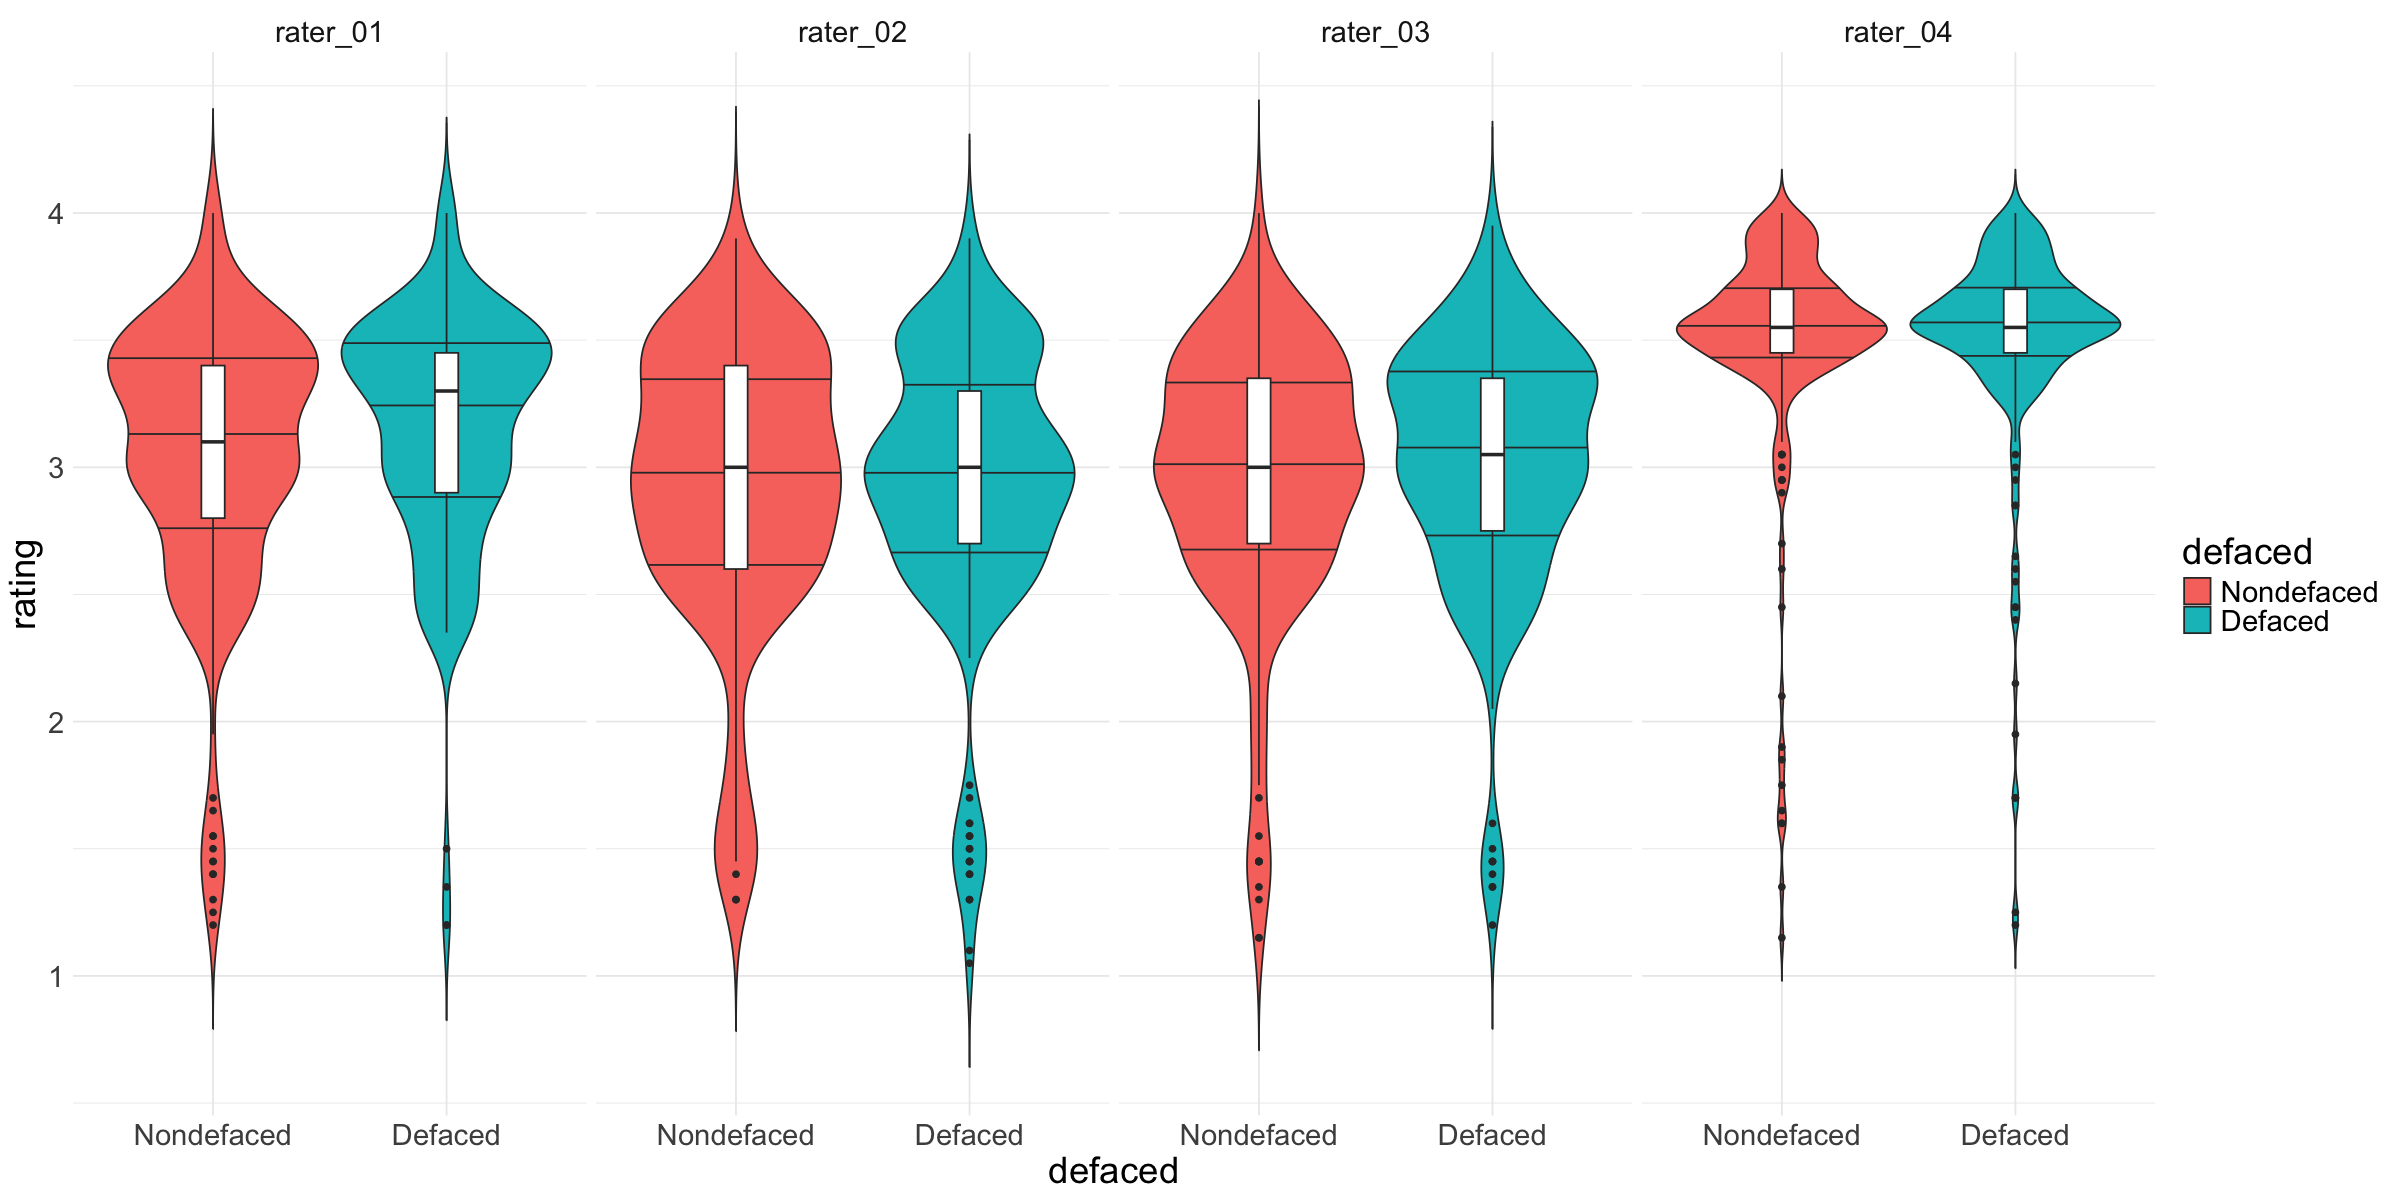

In [39]:
library(ggplot2)
#Increase plot size
options(repr.plot.width=20, repr.plot.height=10)

p <- ggplot(df, aes(x = defaced, y = rating, fill = defaced)) +
  geom_violin(data = subset(df, defaced == "Nondefaced"), trim = FALSE, draw_quantiles = c(0.25, 0.5, 0.75)) +
  geom_violin(data = subset(df, defaced == "Defaced"), trim = FALSE, draw_quantiles = c(0.25, 0.5, 0.75)) +
  geom_boxplot(width = 0.1, fill = "white") +  # Specify colors for alive categories
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ rater_id, ncol = 4)

print(p)

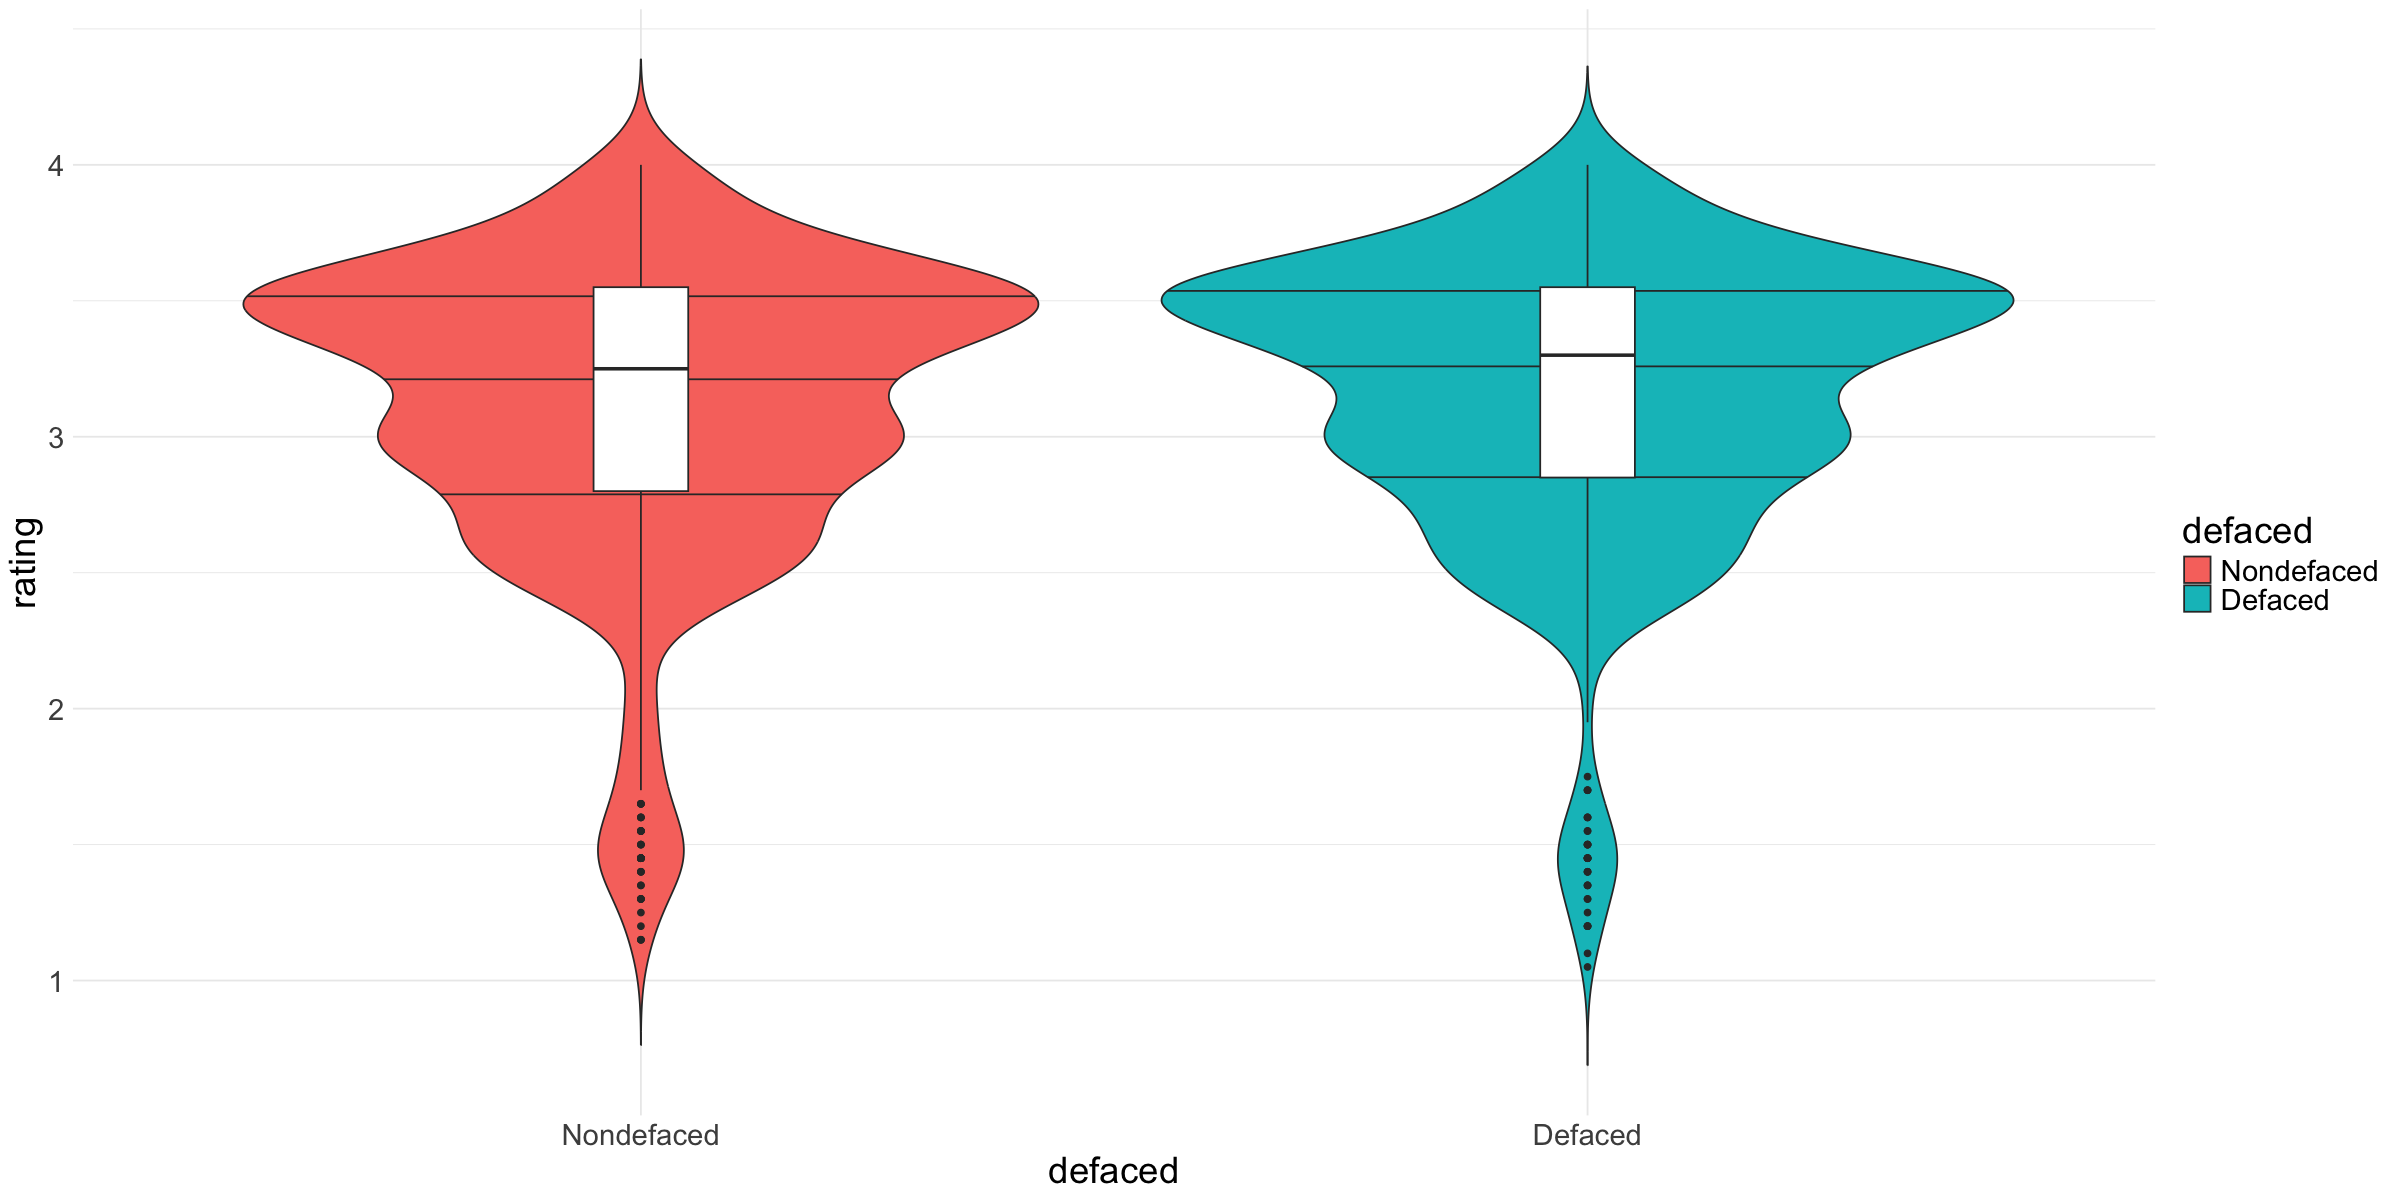

In [40]:
library(ggplot2)
#Increase plot size
options(repr.plot.width=20, repr.plot.height=10)

p <- ggplot(df, aes(x = defaced, y = rating, fill = defaced)) +
  geom_violin(data = df, trim = FALSE, draw_quantiles = c(0.25, 0.5, 0.75)) +
  geom_boxplot(width = 0.1, fill = "white") +  # Specify colors for alive categories
  theme_minimal() +
  theme(text = element_text(size = 22))

print(p)

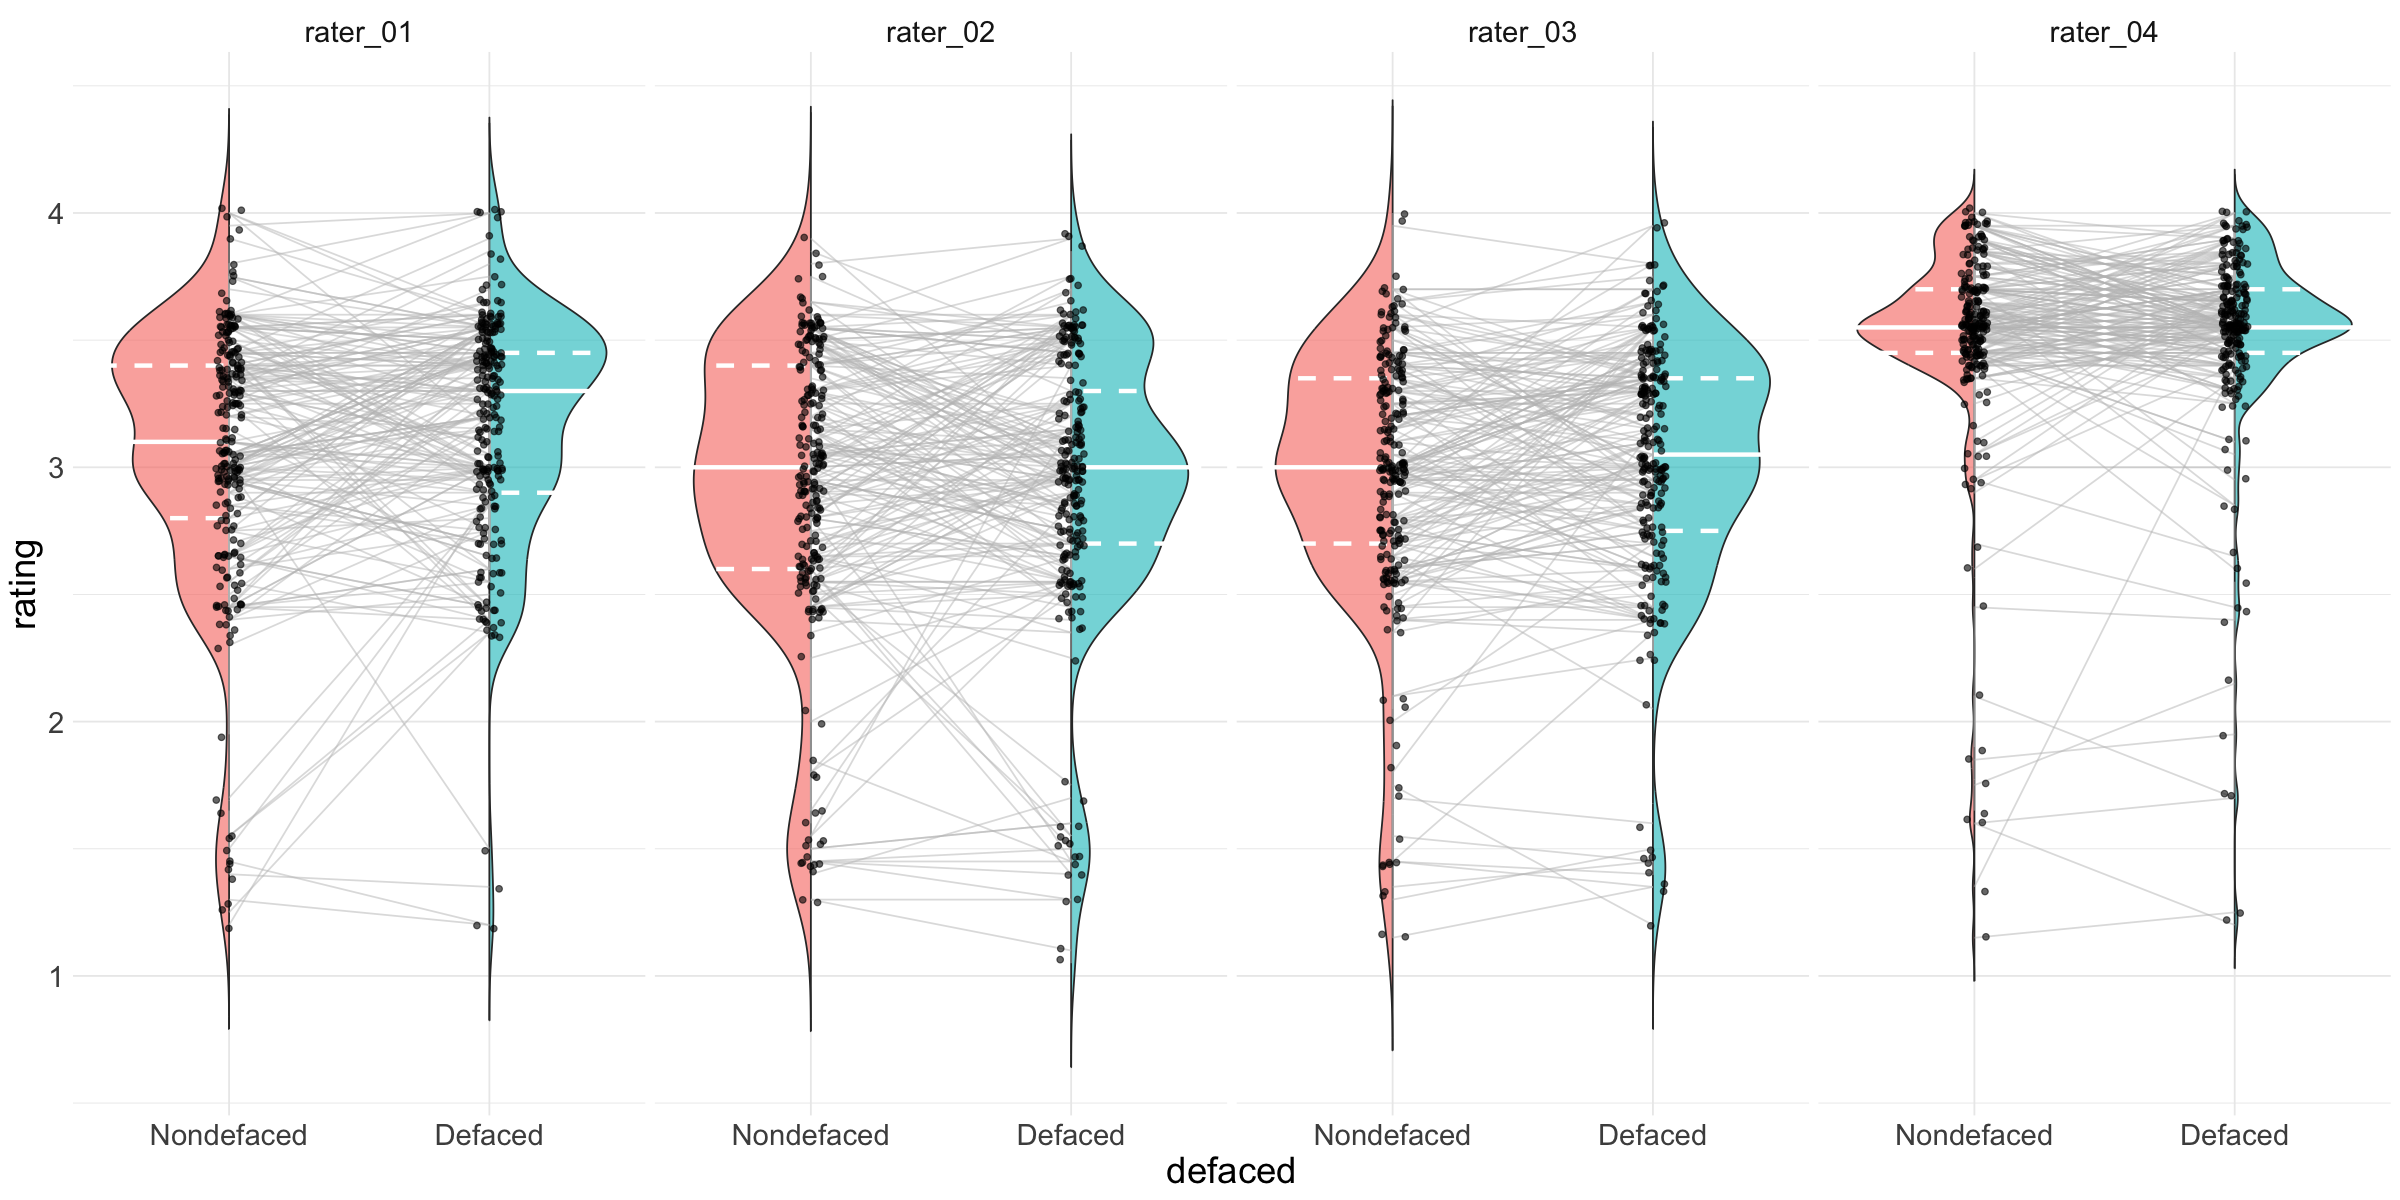

In [41]:
library(see)

p <- ggplot(df, aes(x = defaced, y = rating, group = defaced)) +
  geom_violinhalf(aes(fill = defaced), trim = FALSE, scale = "width", alpha = 0.6, flip=c(0,1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  theme(legend.position = "none") +
  facet_wrap(~ rater_id, ncol = 4)
print(p)

## Bland-Altman plot

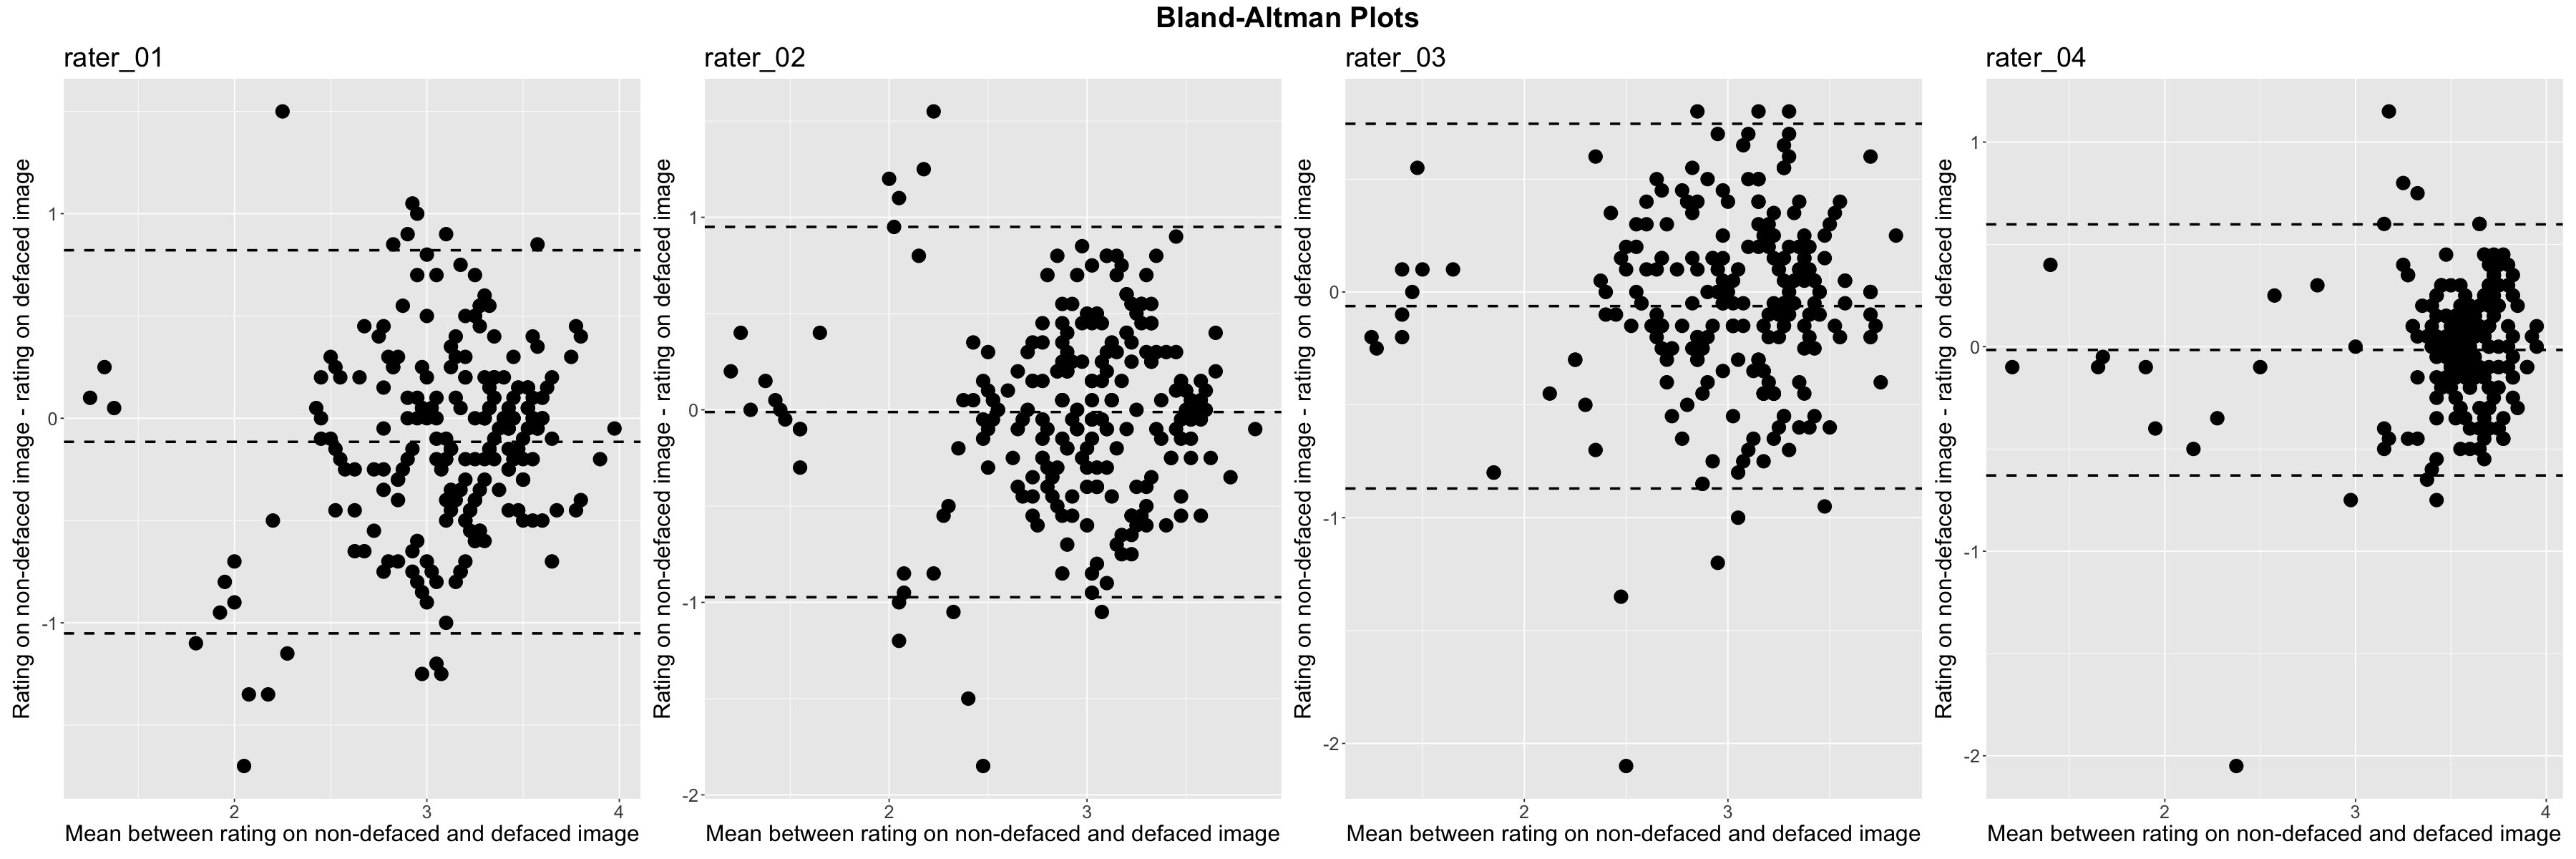

In [42]:
ba <- ba_plot(df_wide_ba, "All raters", 3)
print(ba)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




TableGrob (3 x 8) "arrange": 7 grobs
  z     cells    name                 grob
1 1 (1-2,2-4) arrange       gtable[layout]
2 2 (1-1,5-6) arrange       gtable[layout]
3 3 (1-1,7-8) arrange       gtable[layout]
4 4 (2-2,5-6) arrange       gtable[layout]
5 5 (2-2,7-8) arrange       gtable[layout]
6 6 (3-3,2-8) arrange text[GRID.text.1343]
7 7 (1-3,1-1) arrange text[GRID.text.1344]


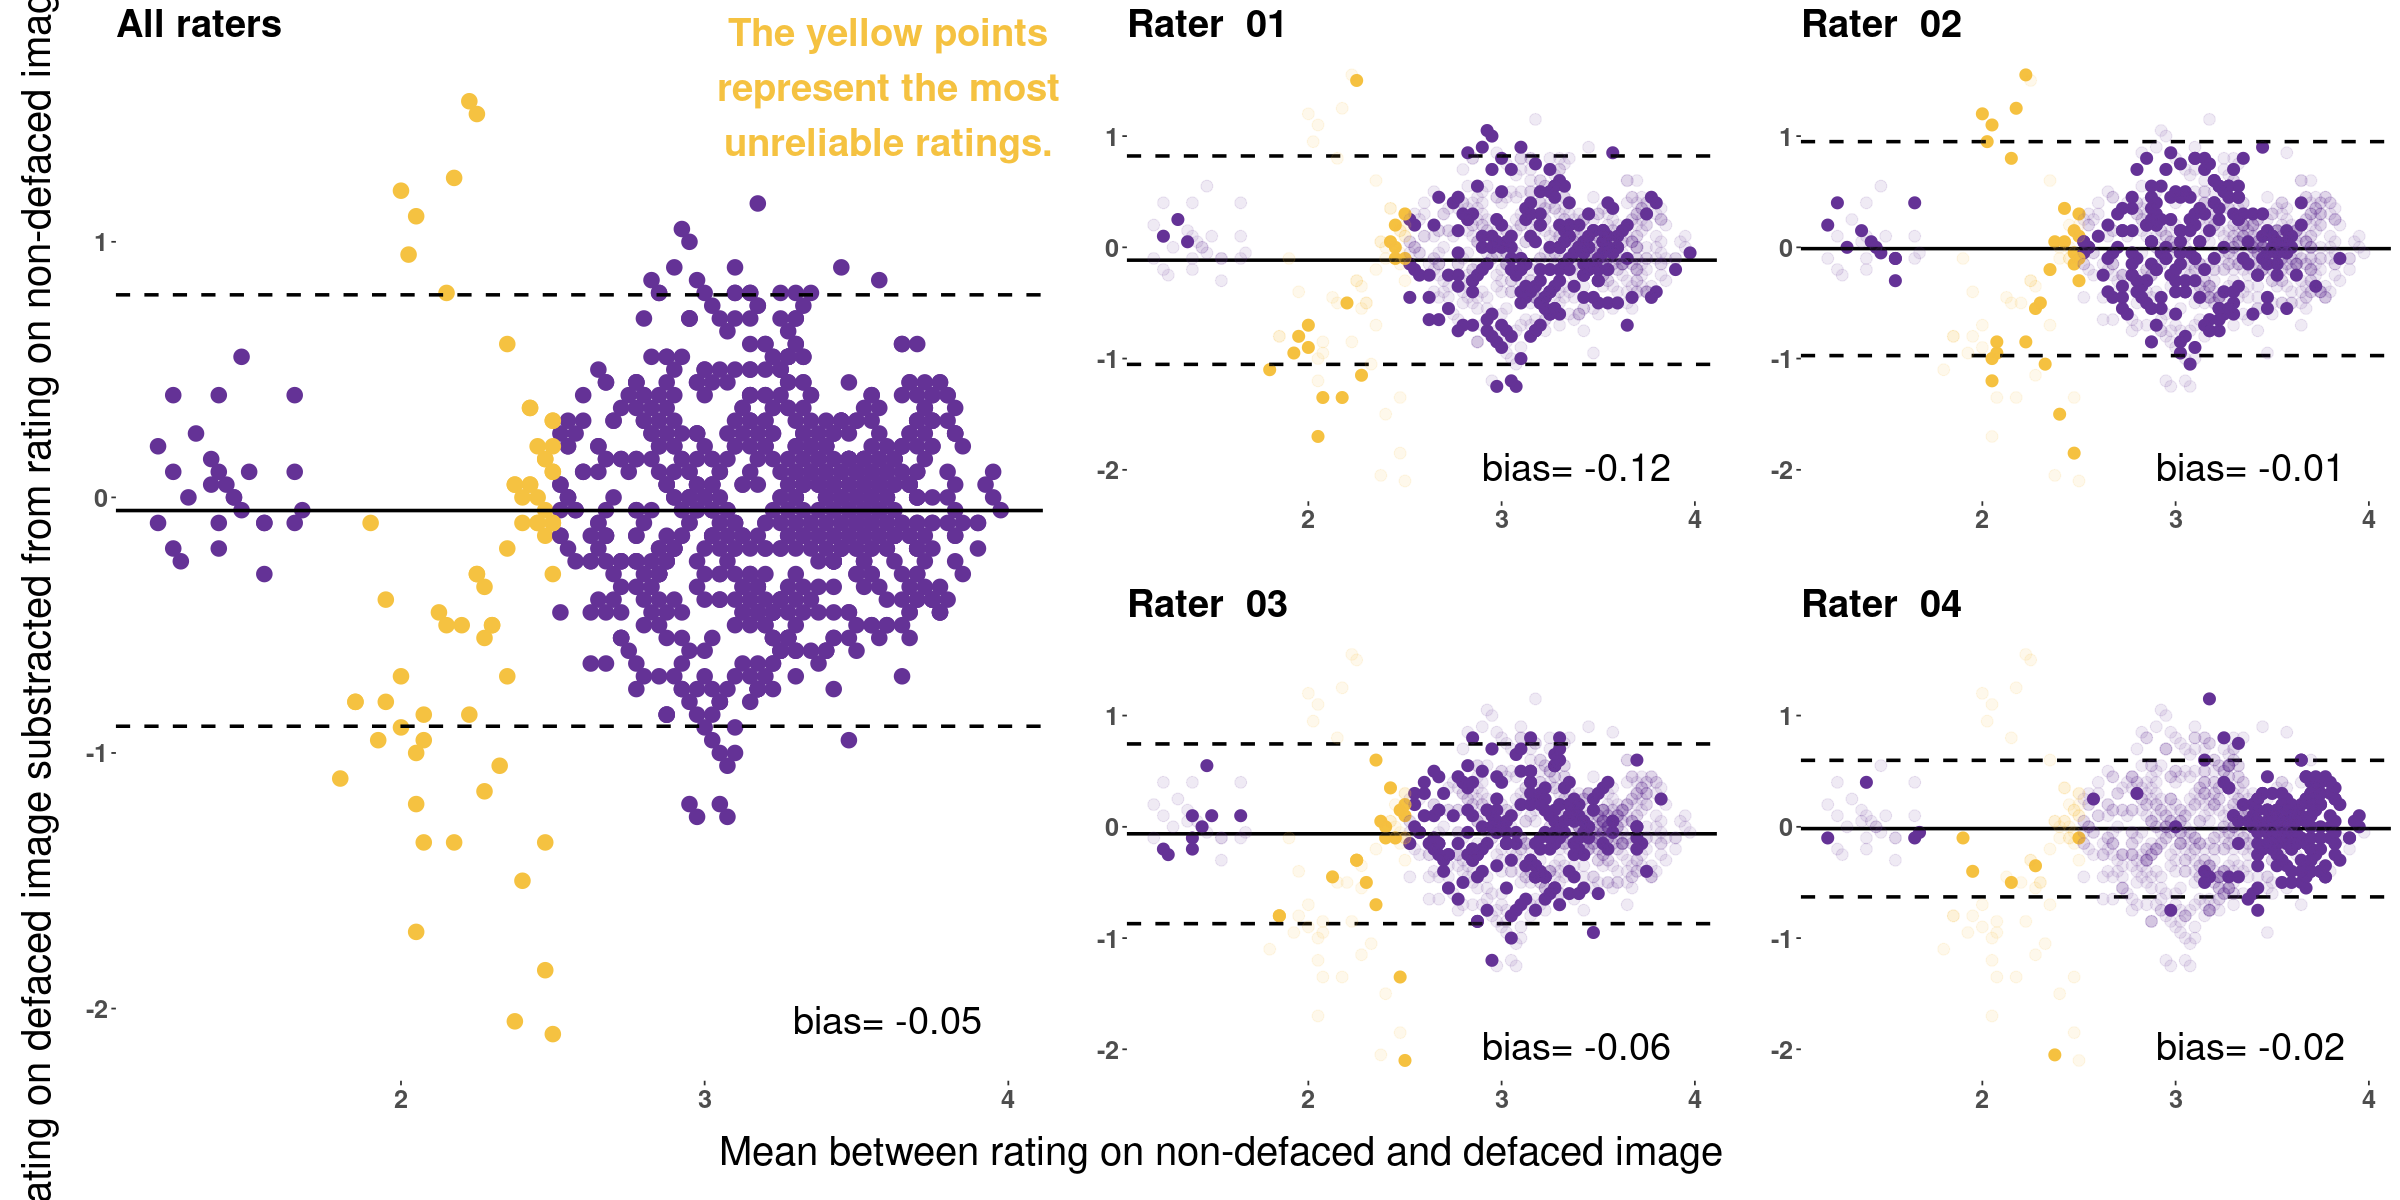

In [21]:
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(scales)
options(repr.plot.width=20, repr.plot.height=10)

plot_list <- list()

color_1 <- "#643296"
color_2 <- "#F5C241"
line_color <- "black"
point_size <- 3

## BA plot with all raters
ba <- ba_plot(df_wide_ba, "All raters", point_size+1)

plot_list <- c(list(ba_all), plot_list)

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  #Keep only the rows corresponding to the rater
  df_rater <- subset(df, rater_id == rater)

  #Pivot to wide format
  df_rater_wide <- df_rater %>%
    pivot_wider(names_from = defaced, values_from = rating, values_fn = list)

  #Decouple the duplicates by writing the first image rating in one line and the second in a new line
  df_rater_wide <- df_rater_wide %>%
    unnest(cols = c("Nondefaced", "Defaced"))

  #Create a new column encoding the mean and color to plot the points
  df_rater_wide <- df_rater_wide %>%
    mutate(mean = (Nondefaced + Defaced) / 2,
          diff = Nondefaced - Defaced,
          pt_color = case_when(
           mean >= 1.75 & mean <= 2.5 ~ color_2,
           TRUE ~ color_1
         ))
  # Calculate mean difference and 1.96 times the standard deviation of the differences
  mean_diff <- mean(df_rater_wide$diff)
  sd_diff <- sd(df_rater_wide$diff)
  upper_limit <- mean_diff + 1.96 * sd_diff
  lower_limit <- mean_diff - 1.96 * sd_diff

  ba <- ggplot(df_rater_wide, aes(x = (Nondefaced + Defaced) / 2, y = Nondefaced - Defaced)) +
    geom_point(size = point_size, aes(color=pt_color)) +
    scale_color_identity() +
    geom_hline(yintercept = mean_diff, color = line_color, linetype = "solid", size = 1) +
    geom_hline(yintercept = upper_limit, color = line_color, linetype = "dashed", size = 1) +
    geom_hline(yintercept = lower_limit, color = line_color, linetype = "dashed", size = 1) +
    geom_point(data = df_wide_ba, aes(x = (Nondefaced + Defaced) / 2, y = Nondefaced - Defaced, color=pt_color), alpha = 0.1, size=point_size) +
    annotate("text", x = max(df_wide_ba$mean), y = min(df_wide_ba$diff), 
           label = paste0("bias= ", round(mean_diff, 2)), 
           hjust = 1.1, vjust = 0, color = line_color, size = 8) +
    theme(legend.position = "none") +
    theme(panel.background = element_blank()) +
    theme(text = element_text(size = 19, face="bold")) +
    xlab("") +
    ylab("") +
    ggtitle(paste("Rater ", strsplit(rater, "_")[[1]][[2]]))    

  plot_list <- c(plot_list, list(ba))
}

## Combine all plots
x_grob <- textGrob("Mean between rating on non-defaced and defaced image", gp = gpar(fontsize = 24), vjust = -0.5)
y_grob <- textGrob("Rating on defaced image substracted from rating on non-defaced image", gp = gpar(fontsize = 24), rot = 90, vjust = 1)
comment_grob <- textGrob("The yellow points\nrepresent the most\nunreliable ratings.", gp = gpar(fontsize = 23, fontface = "bold", col= color_2), x = 0.37, y = 0.985, just = c("centre", "top"))
lay <- rbind(c(1,1,1,2,2,3,3),
             c(1,1,1,4,4,5,5))
final_plot <- grid.arrange(grobs = plot_list, bottom=x_grob, left=y_grob, layout_matrix = lay)
grid.draw(comment_grob)

print(final_plot)


Given the curious observation that low ratings seem to be more biased by defacing, let us plot again the violin and line plot but with low quality and excluded images only.

[1] 186

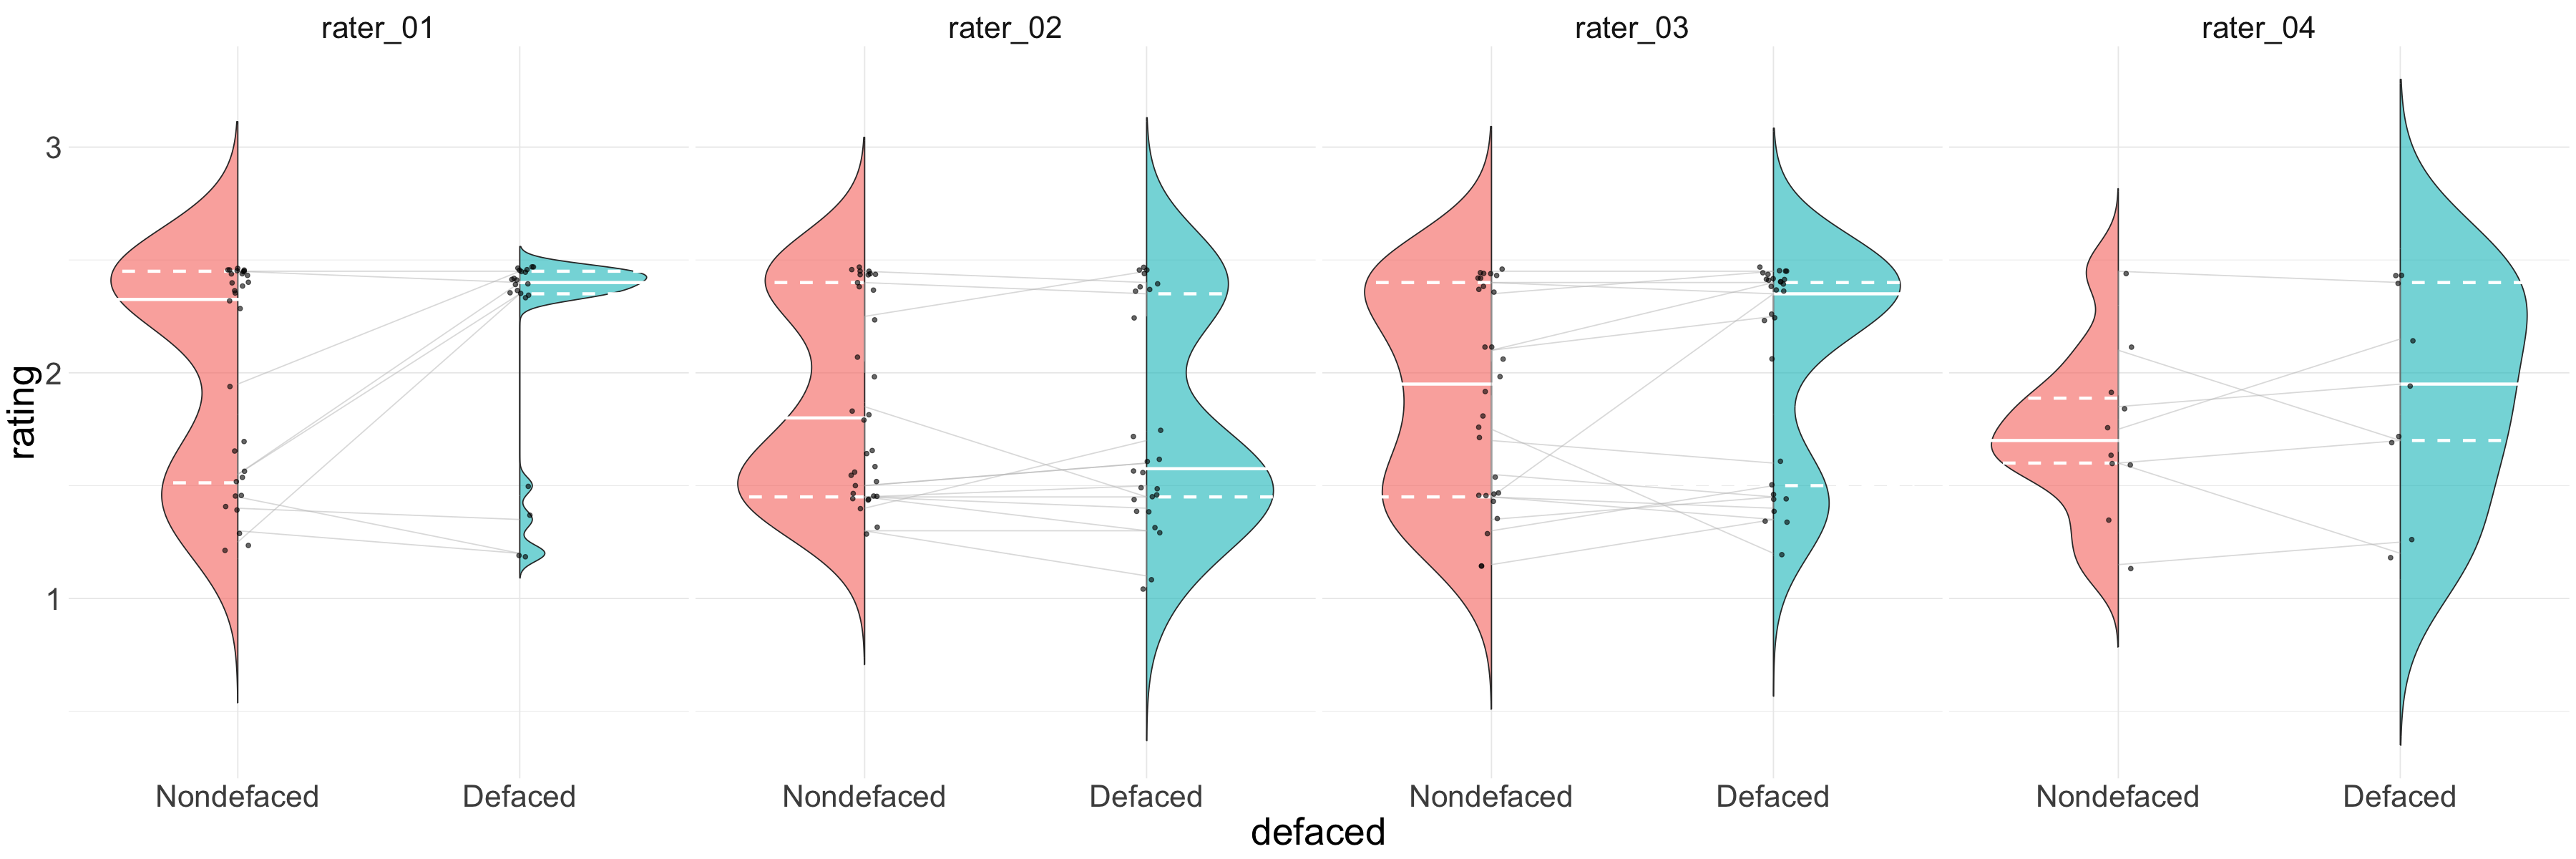

In [43]:
library(see)
df_poor <-  df%>%
  filter(rating <= 2.45)
nrow(df_poor)

p <- ggplot(df_poor, aes(x = defaced, y = rating, group = defaced)) +
  geom_violinhalf(aes(fill = defaced), trim = FALSE, scale = "width", alpha = 0.6, flip=c(0,1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  facet_wrap(~ rater_id, ncol = 4)
print(p)

# Intra-rater reliability
## Violin and line plot

In [44]:
# Identify duplicates as rows that share the same rater_id using dplyr, defaced condition and subject. Those are the 40 subjects that we presented twice in both conditions to assess the intra-rater variability.
df_intra <- df %>% group_by(rater_id, subject) %>% filter(n() > 2)

#Verify that 40 duplicated subjects are found
print(length(unique(df_intra$subject)))

#Add a column in the dataset encoding whether it is the first or the second time the image is presented to this rater 
df_intra$presentation <- ifelse(duplicated(df_intra[, c("subject", "rater_id", "defaced")]), "Second", "First")

df_intra$randomized_id <- NULL

nrow(df_intra)
head(df_intra)

[1] 40


[1] 640

rater_id rating defaced    subject presentation
1   rater_02 2.55   Defaced     72     First       
2   rater_02 2.95   Defaced    248     First       
3   rater_02 2.55   Nondefaced 437     First       
4   rater_02 2.60   Nondefaced 614     First       
5   rater_02 2.65   Nondefaced 525     First       
6   rater_02 3.55   Defaced    335     First       
7   rater_02 2.85   Nondefaced  92     First       
8   rater_02 3.55   Defaced    385     First       
9   rater_03 3.55   Defaced     72     First       
10  rater_03 3.30   Defaced    248     First       
11  rater_03 3.45   Nondefaced 437     First       
12  rater_03 3.00   Nondefaced 614     First       
13  rater_03 3.40   Nondefaced 525     First       
14  rater_03 3.40   Defaced    335     First       
15  rater_03 3.00   Nondefaced  92     First       
16  rater_03 3.10   Defaced    385     First       
17  rater_03 2.70   Defaced    257     First       
18  rater_03 3.10   Defaced    248     Second      
19  rater_03 3.00   Defaced    385     Second      
20  rater_03 2.85   Nondefaced 338     First       
21  rater_03 3.35   Nondefaced 248     First       
22  rater_03 3.50   Nondefaced 481     First       
23  rater_03 3.30   Nondefaced  34     First       
24  rater_03 3.65   Defaced    150     First       
25  rater_03 2.75   Defaced    525     First       
26  rater_03 3.30   Defaced     72     Second      
27  rater_03 3.30   Defaced    611     First       
28  rater_03 3.10   Defaced    610     First       
29  rater_03 3.75   Nondefaced 522     First       
30  rater_03 3.05   Defaced    201     First       
... ...      ...    ...        ...     ...         
611 rater_01 2.70   Defaced    611     Second      
612 rater_01 3.60   Nondefaced  51     Second      
613 rater_01 2.85   Defaced    338     Second      
614 rater_01 3.20   Nondefaced 572     Second      
615 rater_01 3.45   Defaced    253     Second      
616 rater_01 2.90   Nondefaced 385     Second      
617 rater_01 2.65   Nondefaced  94     Second      
618 rater_01 3.90   Nondefaced 633     Second      
619 rater_01 2.45   Nondefaced 256     Second      
620 rater_01 3.50   Nondefaced  67     Second      
621 rater_01 3.30   Defaced    132     Second      
622 rater_01 3.70   Defaced    212     Second      
623 rater_01 1.55   Nondefaced 443     Second      
624 rater_01 3.10   Nondefaced 338     Second      
625 rater_01 3.55   Defaced    445     Second      
626 rater_01 2.70   Nondefaced 598     First       
627 rater_01 3.45   Defaced    130     Second      
628 rater_01 3.55   Defaced    610     Second      
629 rater_01 3.65   Defaced    572     Second      
630 rater_01 2.95   Nondefaced 598     Second      
631 rater_01 3.30   Defaced    150     Second      
632 rater_01 3.30   Defaced    452     Second      
633 rater_01 2.95   Nondefaced  34     Second      
634 rater_01 3.05   Defaced    566     Second      
635 rater_01 3.55   Nondefaced 335     Second      
636 rater_01 4.00   Defaced    609     First       
637 rater_01 3.40   Nondefaced 150     Second      
638 rater_01 3.20   Nondefaced 201     Second      
639 rater_01 4.00   Defaced    609     Second      
640 rater_01 3.45   Nondefaced 130     Second

We visualize the evolution of ratings from defaced versus non-defaced images for each rater.

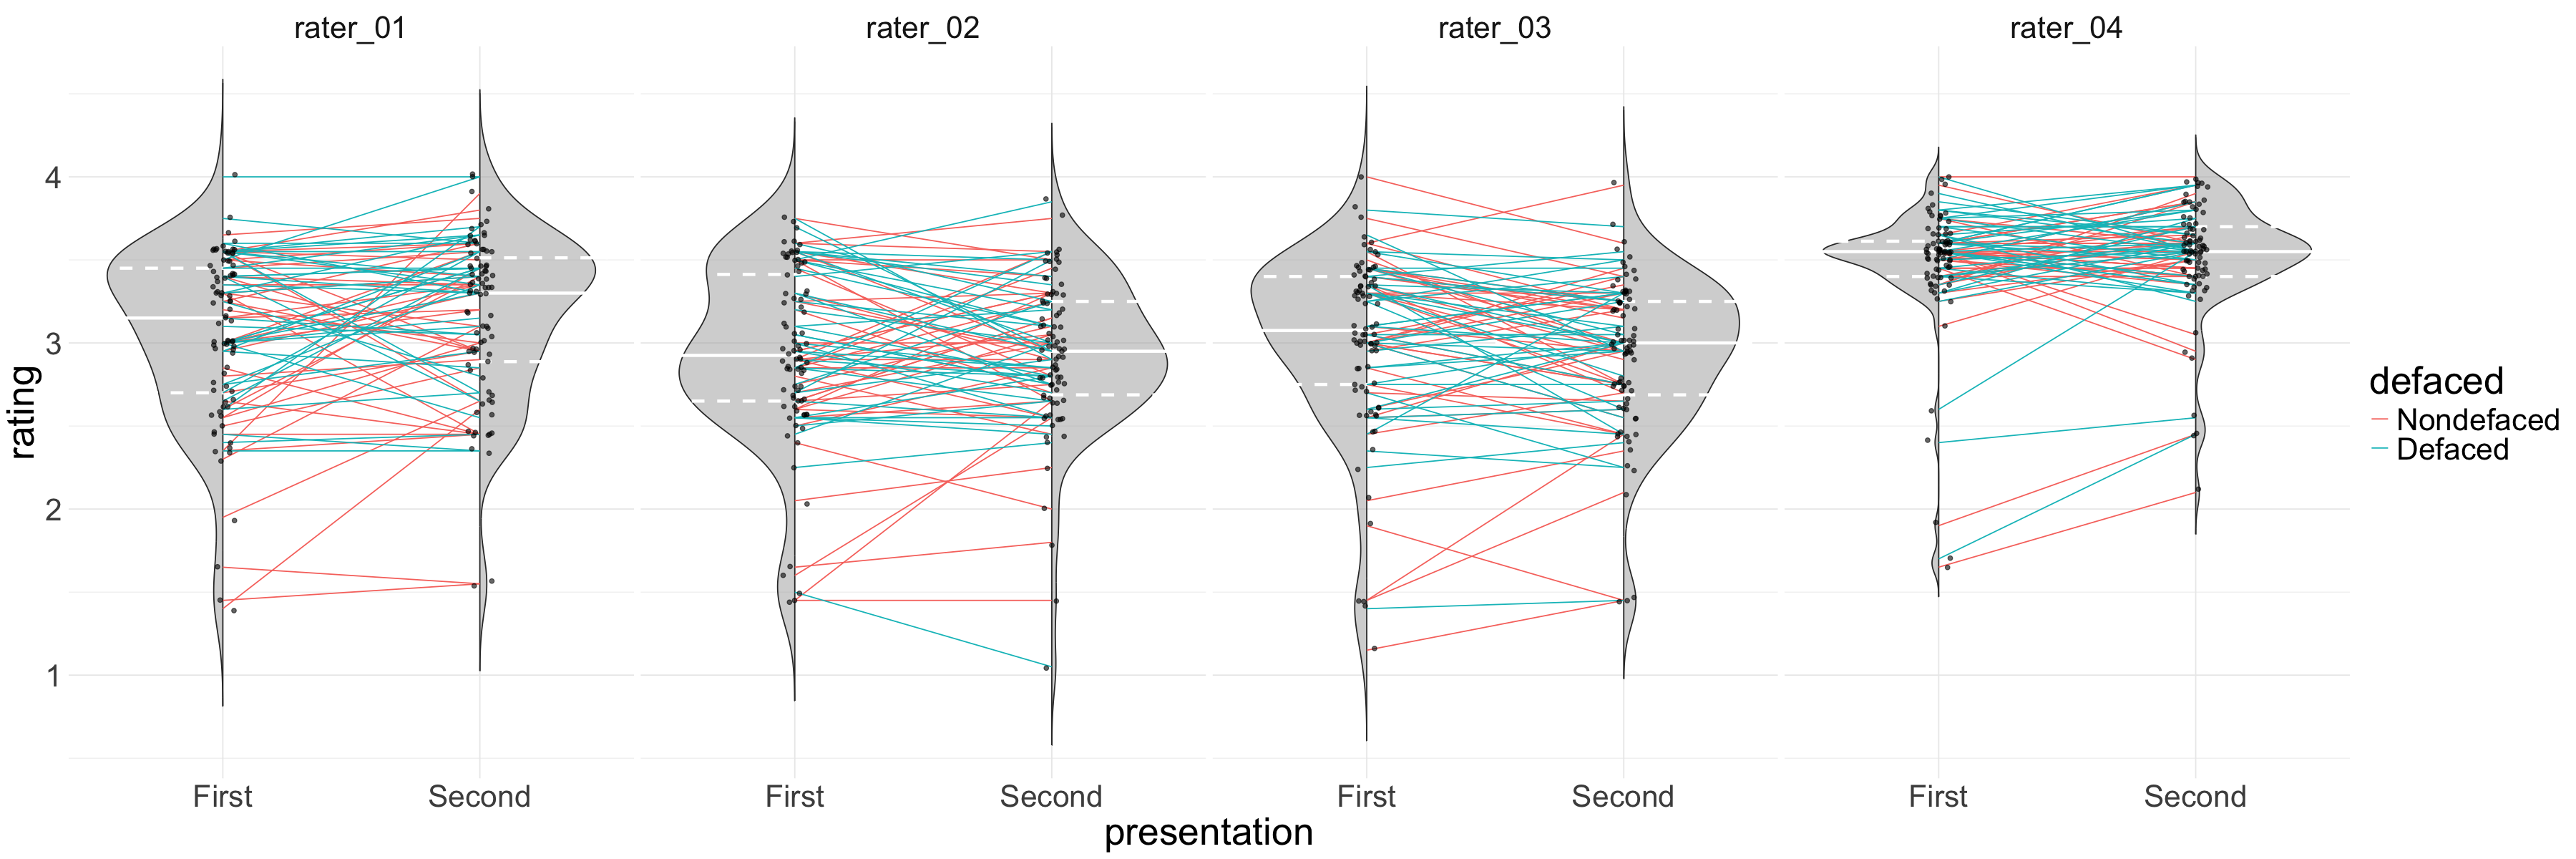

In [45]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, defaced), color = defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  facet_wrap(~ rater_id, ncol = 4)
print(p)

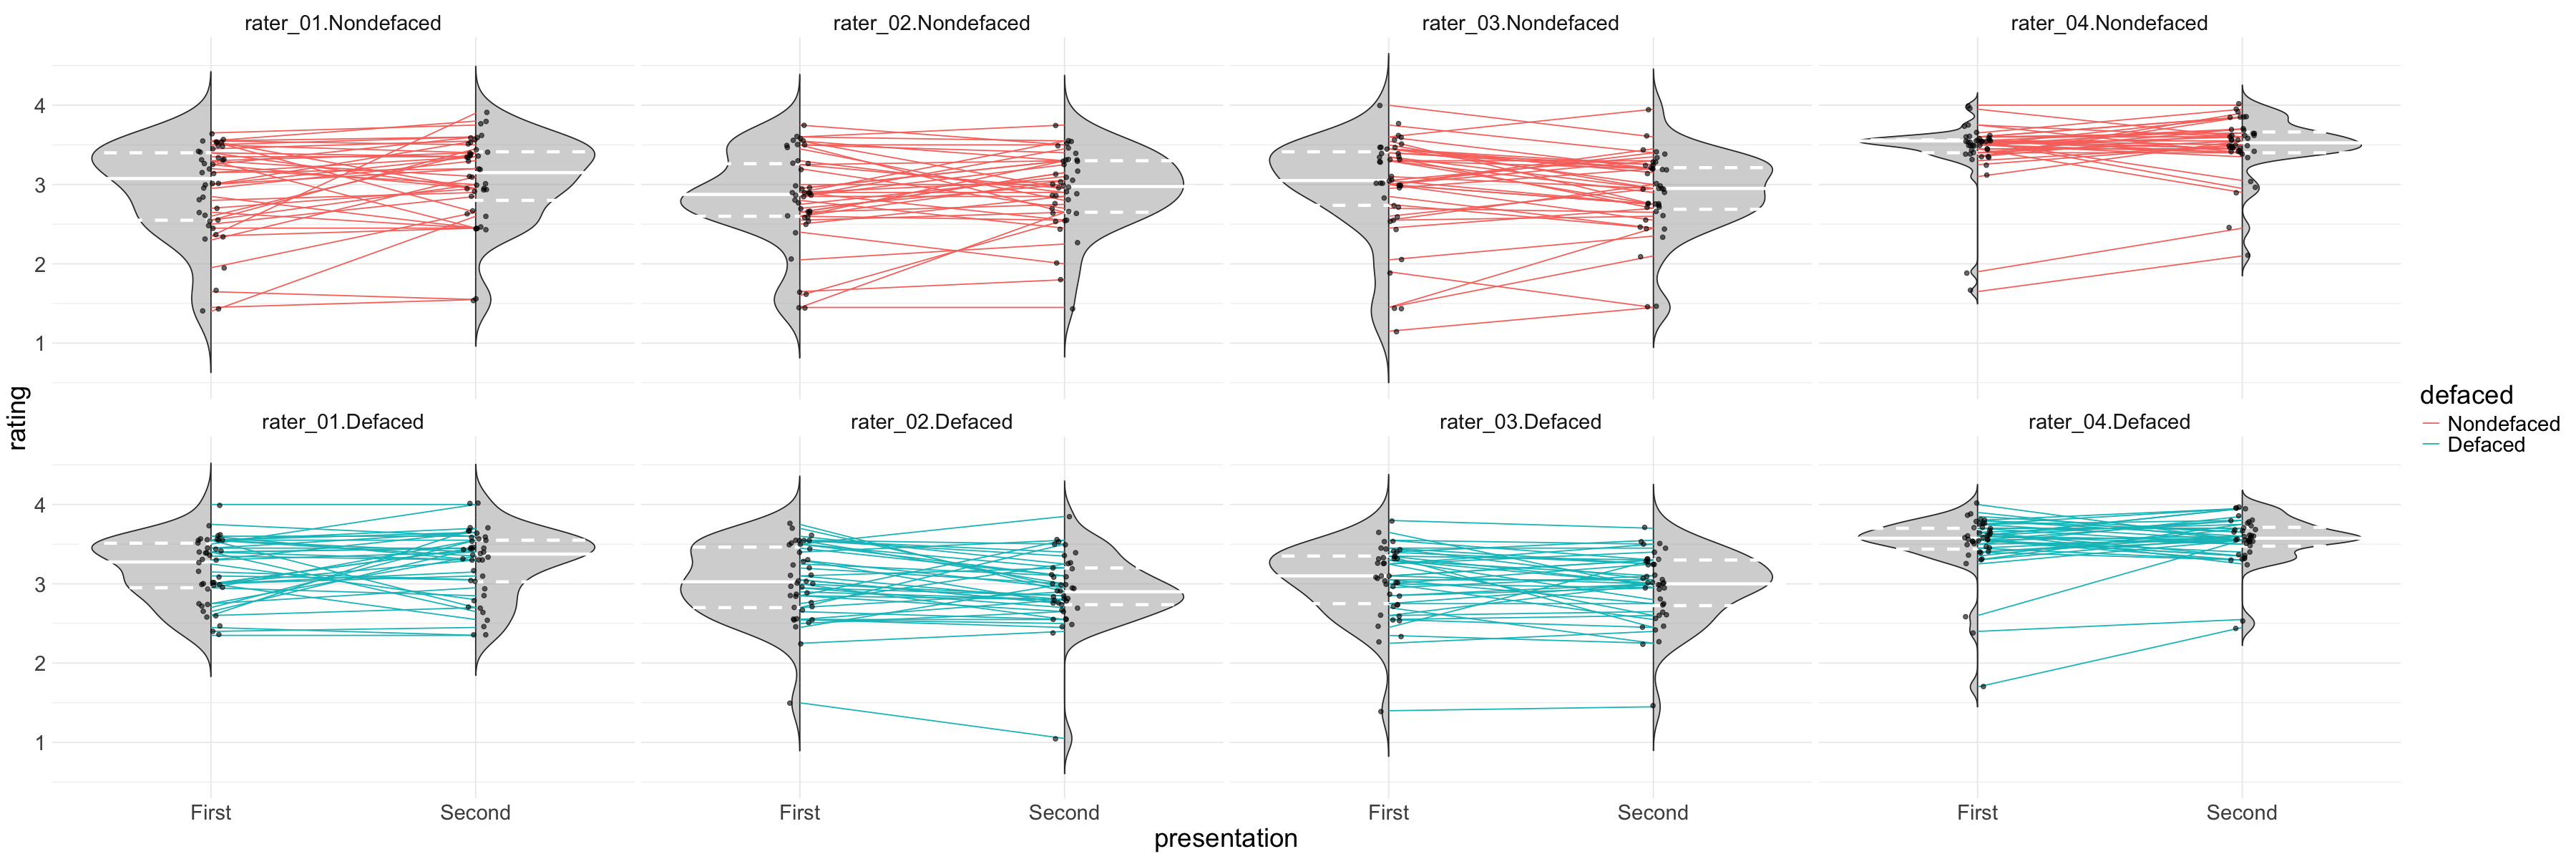

In [46]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, defaced), color = defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_id, defaced), ncol = 4)
print(p)

## Bland-Altman plot

rater_id defaced    subject First Second diff 
1 rater_04 Defaced     72     2.40  2.55   -0.15
2 rater_04 Defaced    248     3.70  3.70    0.00
3 rater_04 Nondefaced 437     3.50  3.85   -0.35
4 rater_04 Nondefaced 614     3.40  3.55   -0.15
5 rater_04 Nondefaced 525     3.55  2.95    0.60
6 rater_04 Defaced    335     3.90  3.55    0.35

[1] "Biases:"
[[1]]
[1] -0.11375

[[2]]
[1] 0.009375

[[3]]
[1] 0.07875

[[4]]
[1] -0.05125

[[5]]
[1] -0.01921875



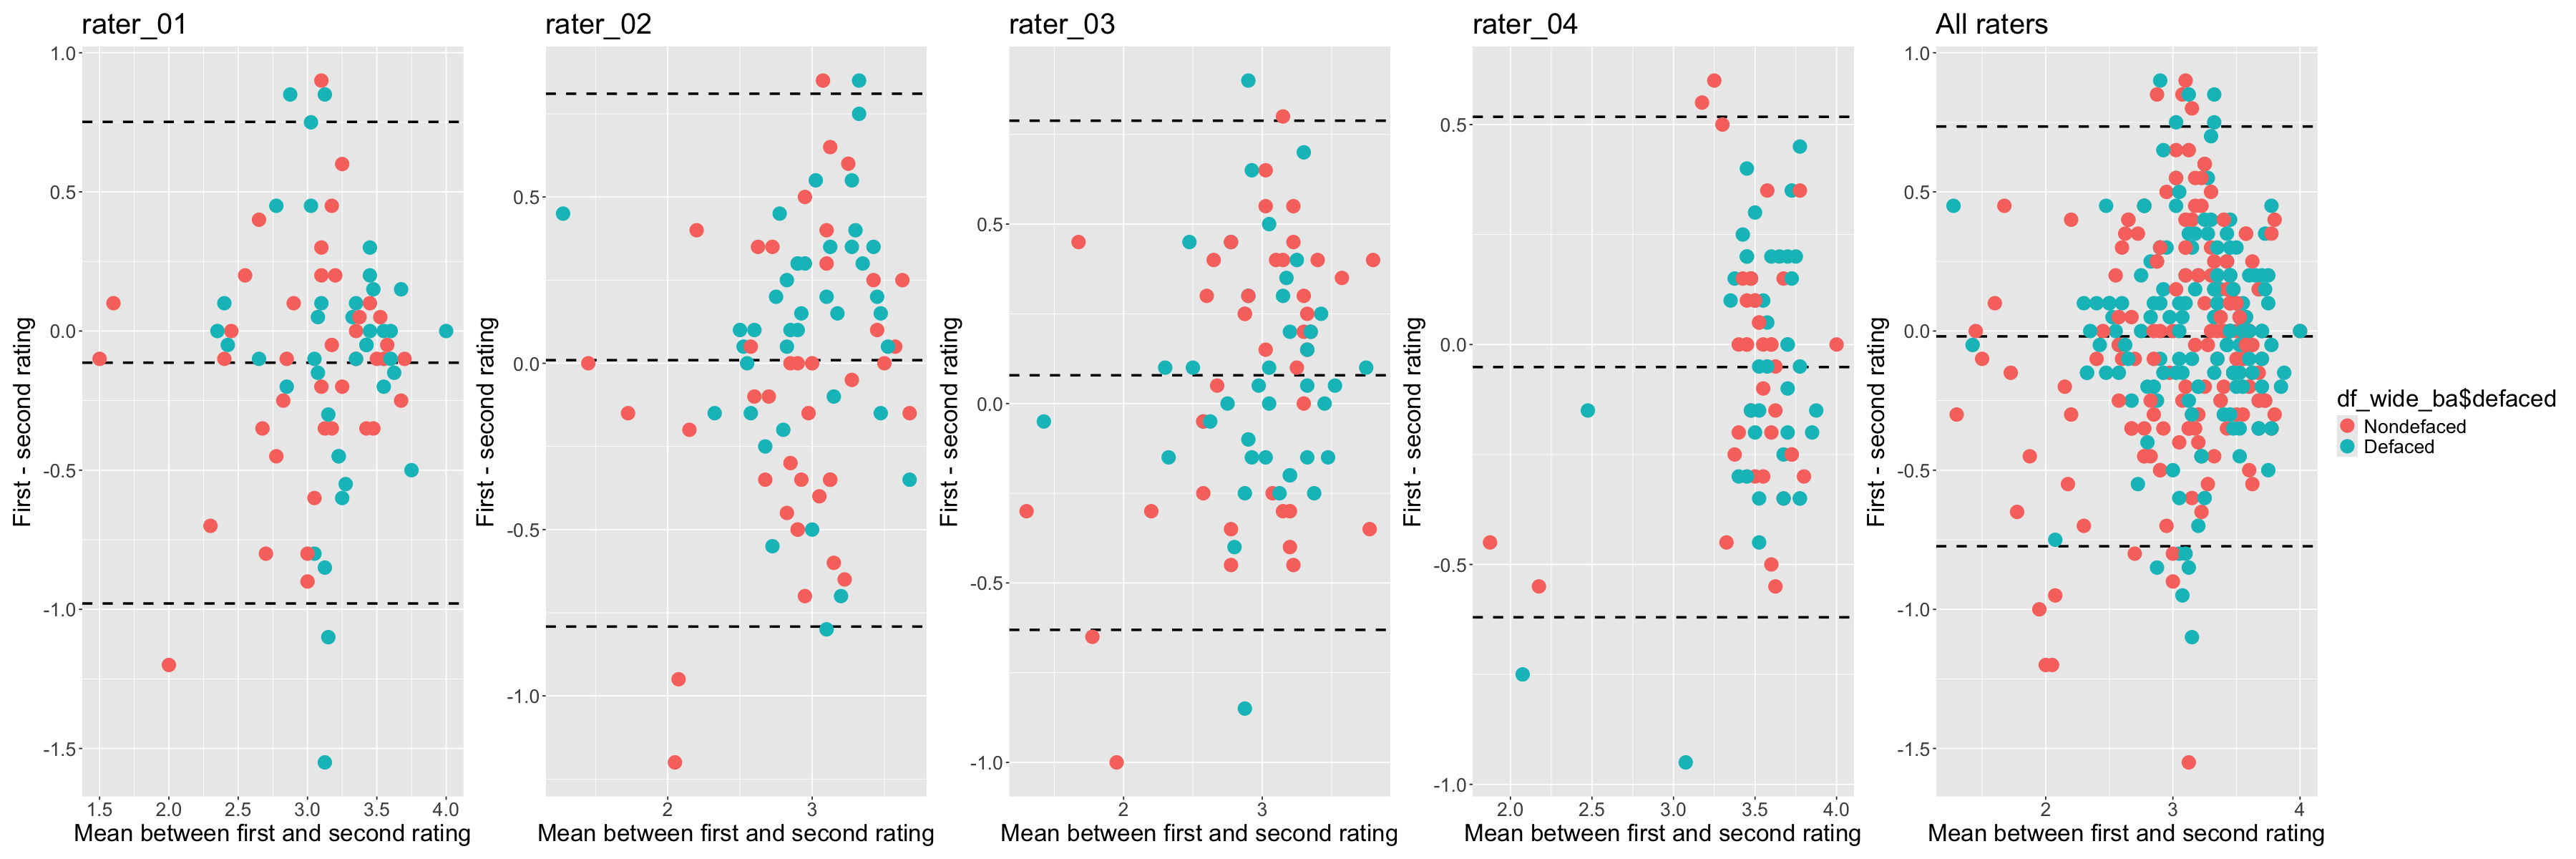

In [47]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)
library(patchwork)
library(BlandAltmanLeh)
options(repr.plot.width=30, repr.plot.height=10)

## BA for each rater separately
#extract list of unique value in df$rater_id
plot_list <- list()
biases <- list()
for (rater in sort(unique(df$rater_id))) {
  #Keep only the rows corresponding to the rater and defaced condition
  df_rater <- subset(df, rater_id == rater)
  df_rater_wide <- df_rater %>%
    pivot_wider(names_from = presentation, values_from = rating)
  
  #Compute bias which corresponds to mean difference
  df_rater_wide <- df_rater_wide %>%
    mutate(diff = First - Second)
  biases <- c(biases, list(mean(df_rater_wide$diff)))

  ba <- bland.altman.plot(df_rater_wide$First, df_rater_wide$Second, graph.sys="ggplot2") +
    geom_point(aes(color = df_rater_wide$defaced), size = 5) +
    theme(text = element_text(size = 20)) +
    xlab("Mean between first and second rating") +
    ylab("First - second rating") +
    ggtitle(rater) +
    theme(legend.position = "none")

  plot_list <- c(plot_list, list(ba))
}

## BA plot with all raters
df_wide_ba <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

# Compute bias which corresponds to mean difference
df_wide_ba <- df_wide_ba %>%
  mutate(diff = First - Second)
biases <- c(biases, list(mean(df_wide_ba$diff)))

ba_all <- bland.altman.plot(df_wide_ba$First, df_wide_ba$Second, graph.sys="ggplot2") +
    geom_point(aes(color = df_wide_ba$defaced), size = 5) +
    theme(text = element_text(size = 20)) +
    xlab("Mean between first and second rating") +
    ylab("First - second rating") +
    ggtitle("All raters")

plot_list <- c(plot_list, list(ba_all))

## Combine plots
combined_plot <- wrap_plots(plot_list, ncol = 5) 

print(combined_plot)

print("Biases:")
print(biases)

## Intra-rater reliability

Let's quantify intra-rater reliability using intraclass correlation (ICC)

In [48]:
#To compute ICC, the data needs to be in wide format
library(tidyr)

df_intra_wide <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

#Add a column that encodes the interaction between defaced and subject
df_intra_wide$image <- interaction(df_intra_wide$defaced, df_intra_wide$subject)
df_intra_wide$defaced <- NULL
df_intra_wide$subject <- NULL
head(df_intra_wide)

rater_id First Second image         
1 rater_02 2.55  2.55   Defaced.72    
2 rater_02 2.95  2.85   Defaced.248   
3 rater_02 2.55  2.65   Nondefaced.437
4 rater_02 2.60  3.05   Nondefaced.614
5 rater_02 2.65  2.75   Nondefaced.525
6 rater_02 3.55  3.00   Defaced.335

In [49]:
# Compute ICC two way mixed effects model and consider absolute agreement
library("irr")

df_intra_wide$image <- NULL

#extract list of unique value in df$rater_id
for (rater in unique(df$rater_id)) {
  #Keep only the rows corresponding to the rater
  df_rater <- subset(df_intra_wide, rater_id == rater)
  df_rater$rater_id <- NULL

  print(sprintf('Intra-rater reliability for %s', rater))
  print(icc(df_rater, model="twoway", type="agreement"))
}


ERROR: Error in library("irr"): aucun package nomm'e 'irr' n'est trouv'e


# Inter-rater reliability

Similarly to intra-rater reliability, we will quantify inter-rater reliability using intraclass correlation (ICC).

In [29]:
library(dplyr)
library(tidyr)
library(purrr)

df_wide <- df %>%
  pivot_wider(names_from = rater_id, values_from = rating, values_fn = list, names_sort = TRUE)
nrow(df_wide)
head(df_wide)


Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




[1] 370

defaced    subject rater_01   rater_02   rater_03   rater_04  
1 Defaced     72     2.6, 2.7   2.55, 2.55 3.55, 3.30 2.40, 2.55
2 Nondefaced 354     3.05       2.85       3.7        3.7       
3 Nondefaced 205     3.55       2.55       3.3        3.7       
4 Defaced    446     3.4        3.45       3.35       3.95      
5 Defaced    248     2.70, 3.55 2.95, 2.85 3.3, 3.1   3.7, 3.7  
6 Nondefaced 437     2.95, 3.30 2.55, 2.65 3.45, 3.15 3.50, 3.85

In [30]:
#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide <- df_wide %>%
  unnest(cols = c(rater_02, rater_03, rater_04, rater_01))
nrow(df_wide)
head(df_wide)


[1] 450

defaced    subject rater_01 rater_02 rater_03 rater_04
1 Defaced     72     2.60     2.55     3.55     2.40    
2 Defaced     72     2.70     2.55     3.30     2.55    
3 Nondefaced 354     3.05     2.85     3.70     3.70    
4 Nondefaced 205     3.55     2.55     3.30     3.70    
5 Defaced    446     3.40     3.45     3.35     3.95    
6 Defaced    248     2.70     2.95     3.30     3.70

In [31]:
library("irr")

df_wide$defaced <- NULL
df_wide$subject <- NULL
print(icc(df_wide, model="twoway", type="consistency"))

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 450 
     Raters = 4 
   ICC(C,1) = 0.542

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
F(449,1347) = 5.74 , p = 5.9e-137 

 95%-Confidence Interval for ICC Population Values:
  0.497 < ICC < 0.587


In [32]:
library(dplyr)
library(tidyr)
library(purrr)
library("irr")

df_wide_defaced <- df %>%
  pivot_wider(names_from = defaced, values_from = rating, values_fn = list, names_sort = TRUE)
nrow(df_wide_defaced)
head(df_wide_defaced)

#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide_defaced <- df_wide_defaced %>%
  unnest(cols = c("Nondefaced", "Defaced"))
nrow(df_wide_defaced)
head(df_wide_defaced)

df_wide_defaced$rater_id <- NULL
df_wide_defaced$subject <- NULL
print(icc(df_wide_defaced, model="twoway", type="consistency"))

[1] 740

rater_id subject Nondefaced Defaced   
1 rater_02  72     2.4, 2.0   2.55, 2.55
2 rater_02 354     2.85       2.55      
3 rater_02 205     2.55       3.6       
4 rater_02 446     3.55       3.45      
5 rater_02 248     3.2, 2.7   2.95, 2.85
6 rater_02 437     2.55, 2.65 2.45, 3.00

[1] 900

rater_id subject Nondefaced Defaced
1 rater_02  72     2.40       2.55   
2 rater_02  72     2.00       2.55   
3 rater_02 354     2.85       2.55   
4 rater_02 205     2.55       3.60   
5 rater_02 446     3.55       3.45   
6 rater_02 248     3.20       2.95

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 900 
     Raters = 2 
   ICC(C,1) = 0.697

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(899,899) = 5.6 , p = 2.56e-132 

 95%-Confidence Interval for ICC Population Values:
  0.662 < ICC < 0.729


# Rating evolution through time

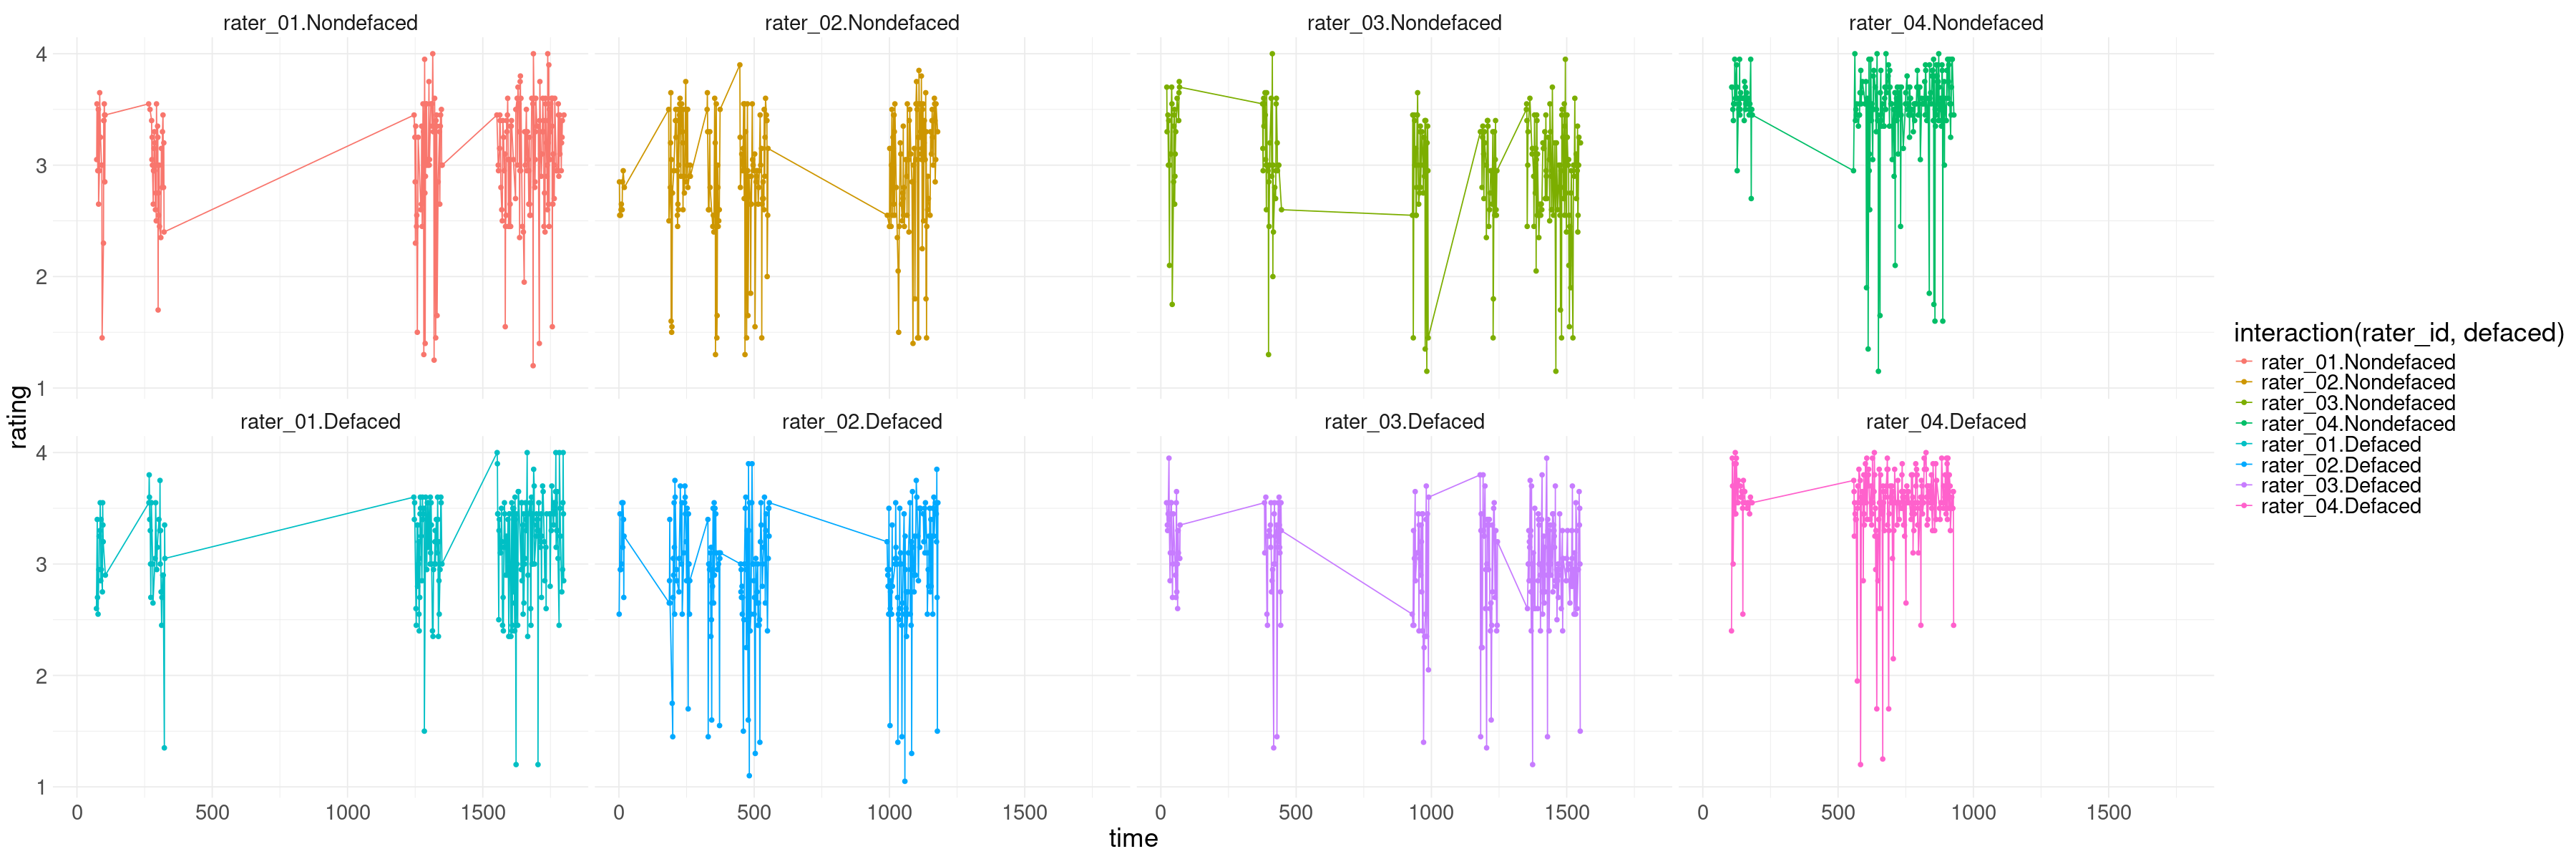

In [33]:
# For each subgroup defined by rater_id and defaced condition, plot the rating evolution through time. 
df$time <- 1:nrow(df)
p <- ggplot(df, aes(x = time, y = rating, group = interaction(rater_id, defaced), color = interaction(rater_id, defaced))) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_id, defaced), ncol = 4)
print(p)

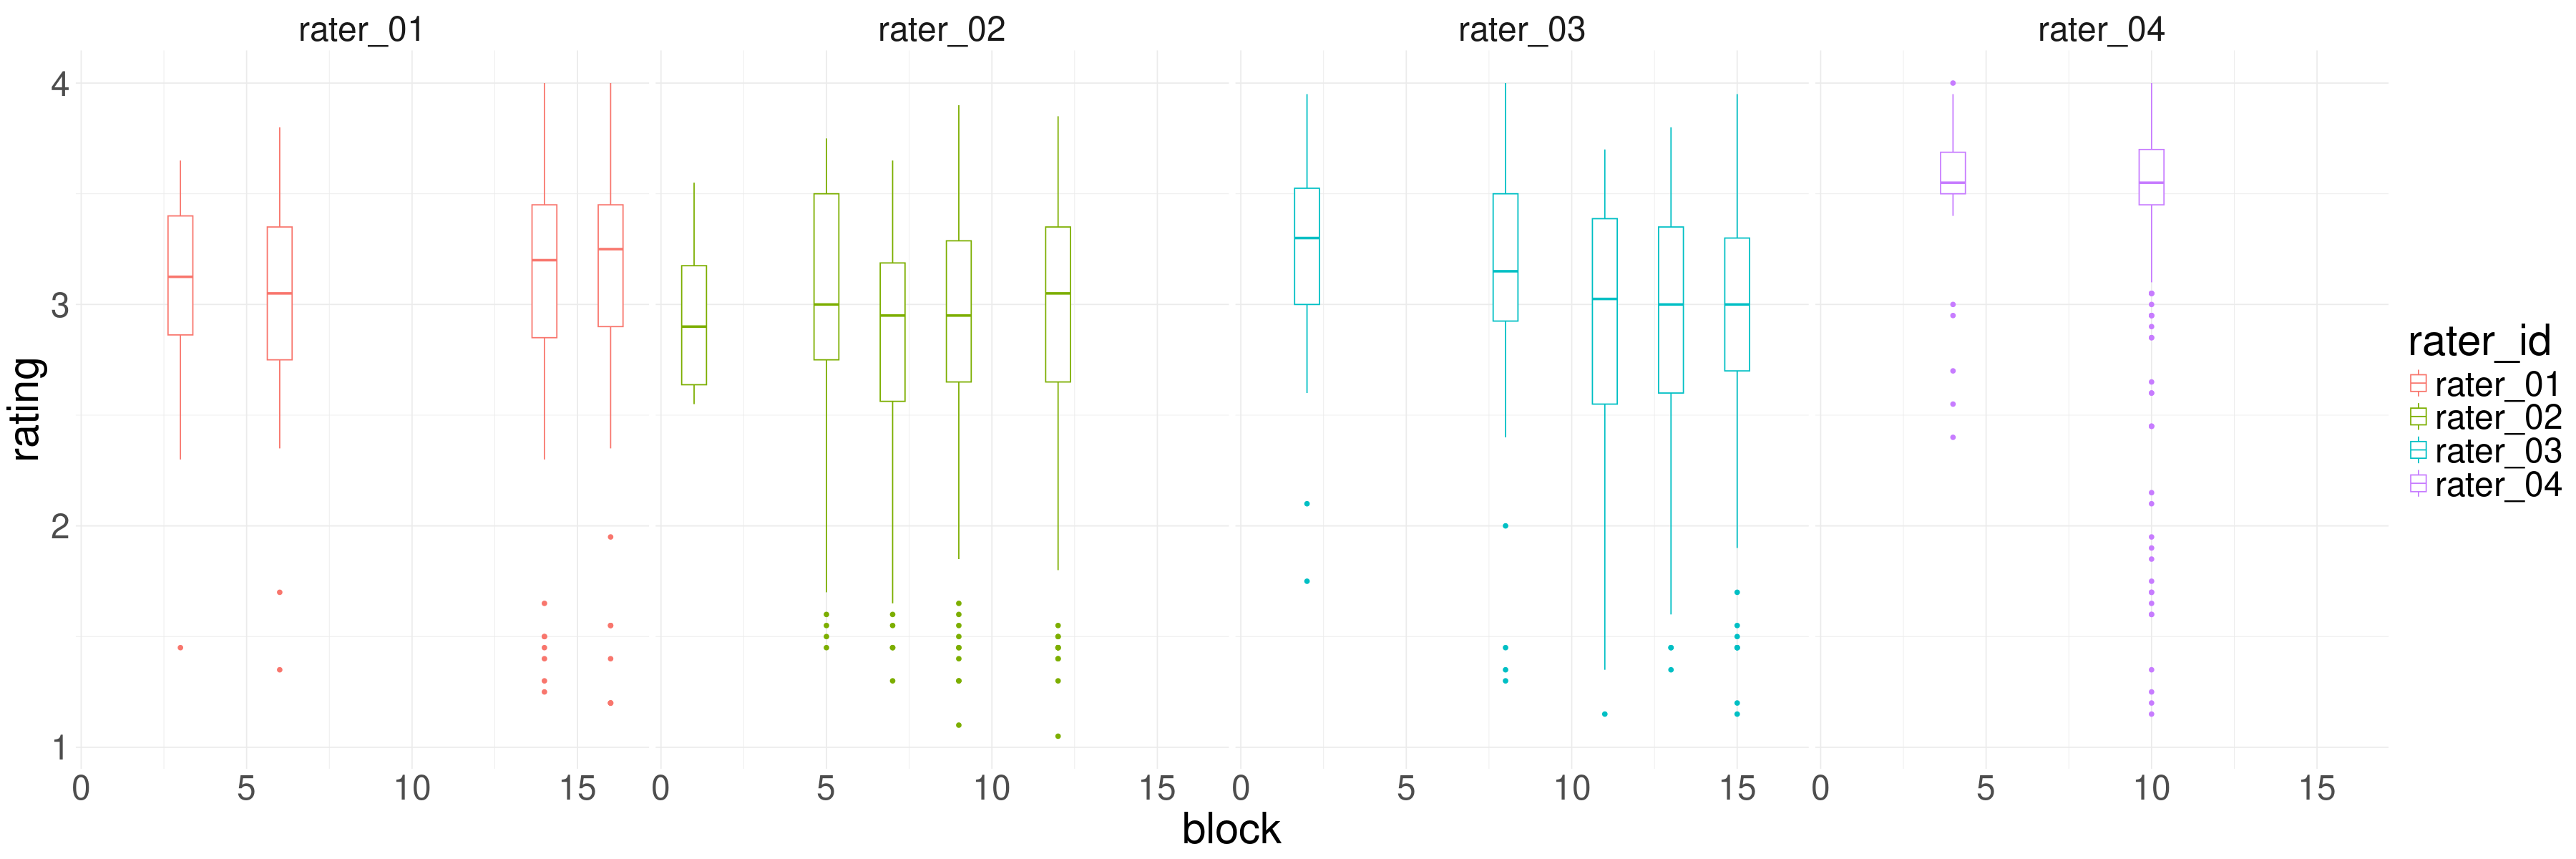

In [34]:
#Identify blocks of ratings from the same raters
rle_blocks <- rle(as.character(df$rater_id))
df$block <- rep(seq_along(rle_blocks$lengths), rle_blocks$lengths)

#For each block, plot a boxplot of the distribution of the ratings without differentiating between defaced and nondefaced
# order the block by rater_id
p <- ggplot(df, aes(x = block, y = rating, group = block, color=rater_id)) +
  geom_boxplot() +
  theme_minimal() +
  theme(text = element_text(size = 36)) +
  facet_wrap(~ rater_id, ncol = 4)

print(p)